<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/%E8%BC%95%E6%B2%B9%E6%A1%88%E5%AD%90%E5%90%84%E7%A8%AE%E7%AE%97%E6%B3%95%E4%BB%A3%E7%A2%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# get_oof

In [0]:
from sklearn.model_selection import KFold
def get_oof(model ,x_train, y_train, x_test):
    kf = KFold(n_splits=5,random_state=0)
    oof_train = np.zeros((len(x_train),))
    oof_test = np.zeros((len(x_test),))
    oof_test_skf = np.empty((5, len(x_test)))

    for i, (train_index, test_index) in enumerate(kf.split(x_train)):
        x_tr = x_train.loc[train_index]
        y_tr = y_train.loc[train_index]
        x_te = x_train.loc[test_index]

        model.fit(x_tr, y_tr)

        oof_train[test_index] = model.predict(x_te)
        oof_test_skf[i, :] = model.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import warnings 
warnings.simplefilter('ignore')

def 集成學習(X_train,y_train,X_test,tuning_meta_model=False,meta_model_params=None):
  X_train = X_train.reset_index(drop=True)
  X_test = X_test.reset_index(drop=True)
  y_train = y_train.reset_index(drop=True)
  
  # def base model
  base_models = [
      RandomForestRegressor(random_state=0),
      LinearRegression(),
      KNeighborsRegressor(),
      XGBRegressor(objective="reg:squarederror",random_state=0)]
  
  # def meta model
  meta_model = SVR()
  
  # get all base model's oof_train and oof_test
  all_oof_train = np.empty((len(X_train),0))
  all_oof_test = np.empty((len(X_test),0))
  for model in base_models:
    oof_train,oof_test = get_oof(model,X_train,y_train,X_test)
    all_oof_train = np.hstack((all_oof_train,oof_train))
    all_oof_test = np.hstack((all_oof_test,oof_test))

  # train and tunning meta model
  if tuning_meta_model == True:
    cv = RandomizedSearchCV(estimator = meta_model,
                            param_distributions = meta_model_params,
                            n_jobs = -1,
                            n_iter = 20,
                            cv = 3)
    cv.fit(all_oof_train,y_train)
    meta_model = cv.best_estimator_
  
  # not tunning meta model
  if tuning_meta_model == False:
    meta_model.fit(all_oof_train,y_train)
  
  # return meta model predict
  return meta_model.predict(all_oof_test)

# 評估

In [0]:
from sklearn.metrics import r2_score
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(((y_pred - y_true) ** 2).mean())

def mape(y_true, y_pred,dropinf=False):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    ape = np.abs((y_true - y_pred) / y_true)
    if dropinf == True:
      ape = ape[np.isfinite(ape)]
    return np.mean(ape) * 100

def metric(y_true,y_pred,y_name):
  R2 = r2_score(y_true,y_pred)
  RMSE = rmse(y_true,y_pred)
  MAPE = mape(y_true,y_pred)
  return pd.DataFrame({'R2':R2,'RMSE':RMSE,'MAPE':MAPE},index=[y_name])

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# trainset

In [5]:
import pandas as pd
train = pd.read_csv('/content/drive/My Drive/台塑輕油案子/輕油實驗數據(保留大部份欄位,三個基本規則清洗過).csv')
X = train[['T10','T50','T90','N+A in Feed']].rename(columns={'N+A in Feed':'NA'})
y = train.iloc[:,17:-1]
train = X.join(y)
train.head()

,T10,T50,T90,NA,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,100.5,119.2,146.5,31.978,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319
1,99.6,117.9,145.5,31.568,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303
2,100.0,118.8,145.6,31.344,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289
3,100.4,118.6,142.9,31.453,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281
4,100.4,118.1,142.2,32.190,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290


# testset

In [6]:
test = pd.read_csv('/content/drive/My Drive/台塑輕油案子/test_without_outlier.csv')
X_test = test[['T10','T50','T90','N+A']].rename(columns={'N+A':'NA'})
y_test = test.iloc[:,4:]
y_test.columns = y.columns
test = X_test.join(y_test)
test.head()

,T10,T50,T90,NA,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A
0,98.6,119.2,146.1,40.133,1.142,0.616,0.217,3.745,2.577,4.028,0.557,7.669,5.9900,10.206,3.075,7.920,8.036,7.039,5.438,5.263,9.537,4.877,3.481,1.088,5.652,0.618,0.597
1,105.4,122.2,148.2,32.175,0.122,0.078,0.029,3.955,1.563,2.407,0.400,10.016,7.2633,6.573,2.809,9.544,9.815,5.135,5.482,6.793,10.850,4.308,3.963,1.069,6.025,0.585,0.484
2,105.8,122.7,149.2,31.428,0.098,0.064,0.020,3.920,1.447,2.296,0.396,10.236,7.3480,6.259,2.797,9.655,9.986,4.942,5.453,6.947,10.996,4.269,3.997,1.034,6.107,0.543,0.456
3,105.4,122.4,147.6,31.390,0.122,0.085,0.021,3.900,1.437,2.274,0.397,10.259,7.3560,6.234,2.820,9.670,10.146,4.928,5.476,6.953,11.026,4.264,3.982,1.013,6.054,0.545,0.449
4,105.4,122.6,148.2,32.418,0.072,0.049,0.015,3.873,1.369,2.206,0.489,10.213,7.3190,6.009,2.968,9.564,10.052,4.769,6.584,6.866,10.892,4.169,4.227,0.930,5.828,0.519,0.463


# 專業分群

In [0]:
from xgboost import XGBClassifier

def 專業分群(train,test,cun_num=5):
  '''
  丟入訓練和測試資料,加入群標籤後return
  '''
  #訓練資料均溫
  train['AVG_T'] = train[['T10','T50','T90']].mean(axis=1)
  #測試資料均溫
  test['AVG_T'] = test[['T10','T50','T90']].mean(axis=1)
  #訓練資料依據均溫切群
  train['群代碼'] = pd.qcut(train['AVG_T'],cut_num,labels = [ i for i in range(cut_num)]).astype('int')
  #利用4000筆資料訓練一個分群器
  xgb_c = XGBClassifier().fit(train[['AVG_T']].sample(4000,random_state=0),train['群代碼'].sample(4000,random_state=0))
  print('預測準度:',xgb_c.score(train[['AVG_T']],train['群代碼']))
  #利用分群器對測試資料產生群代碼
  test['群代碼'] = xgb_c.predict(test[['AVG_T']])
  return train,test

# def x_col y_col

In [8]:
x_columns = X.columns.tolist()
y_columns = y.columns.tolist()
print(len(x_columns))
print(len(y_columns))

4
23


# ART2分群

In [9]:
from sklearn.manifold import Isomap
from sklearn.preprocessing import StandardScaler
import ART2_Ricky

def ART2專業分群(train,test):
  '''
  輸入train test return 加上群標籤的 train test
  '''
  scaler = StandardScaler()
  iso = Isomap(n_components=3)
  ART2 = ART2_Ricky.ART2(rho=0.96)
  train['群代碼'] = ART2.fit_transform(iso.fit_transform(scaler.fit_transform(train[x_columns])))
  test['群代碼'] = ART2.transform(iso.transform(scaler.transform(test[x_columns])))
  return train,test
#執行
train,test = ART2專業分群(train,test)
#看結果
print(train['群代碼'].value_counts())
print(test['群代碼'].value_counts())

3.0    1550
0.0    1168
1.0     923
2.0     498
4.0     382
Name: 群代碼, dtype: int64
3.0    77
0.0    57
1.0    31
2.0     5
Name: 群代碼, dtype: int64


# 特徵工程

In [0]:
def 特徵工程(df):
  df['T90-T50'] = df['T90'] - df['T50']
  df['T50-T10'] = df['T50'] - df['T10']
  return df

def do特徵工程(train,test):
  X_train = 特徵工程(train[x_columns])
  train = X_train.join(train.drop(x_columns,axis=1))
  X_test = 特徵工程(test[x_columns])
  test = X_test.join(test.drop(x_columns,axis=1))
  return train,test

train,test = do特徵工程(train,test)

# 檢查資料(應有特徵工程項和群落標籤)

In [11]:
train.head()

,T10,T50,T90,NA,T90-T50,T50-T10,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A,群代碼
0,100.5,119.2,146.5,31.978,27.3,18.7,0.272,0.132,0.059,5.293,2.570,2.819,0.494,10.395,8.070,6.411,2.917,9.138,9.649,4.810,5.373,6.405,9.759,4.590,3.661,0.875,5.257,0.525,0.319,0.0
1,99.6,117.9,145.5,31.568,27.6,18.3,0.297,0.151,0.062,5.089,2.531,2.804,0.499,10.074,7.958,6.395,2.894,8.970,9.548,4.753,5.443,6.324,9.899,4.301,2.995,0.881,5.591,1.119,0.303,0.0
2,100.0,118.8,145.6,31.344,26.8,18.8,0.262,0.126,0.061,5.107,2.571,2.771,0.492,10.069,7.913,6.378,2.890,9.006,9.591,4.778,5.468,6.360,9.983,4.274,2.979,0.865,5.641,0.964,0.289,0.0
3,100.4,118.6,142.9,31.453,24.3,18.2,0.224,0.105,0.060,4.894,2.497,2.650,0.469,10.015,7.685,6.376,2.866,9.133,9.708,4.889,5.510,6.444,10.182,4.420,2.964,0.830,5.637,0.968,0.281,1.0
4,100.4,118.1,142.2,32.190,24.1,17.7,0.243,0.117,0.061,4.946,2.503,2.695,0.477,10.053,7.765,6.394,2.877,9.101,9.676,4.855,5.500,6.416,10.115,4.347,3.725,0.835,4.823,0.969,0.290,1.0


In [12]:
test.head()

,T10,T50,T90,NA,T90-T50,T50-T10,C5NP,C5IP,C5N,C6NP,C6IP,C6N,C6A,C7NP,C7IP,C7N,C7A,C8NP,C8IP,C8N,C8A,C9NP,C9IP,C9N,C9A,C10NP,C10IP,C10N,C10A,群代碼
0,98.6,119.2,146.1,40.133,26.9,20.6,1.142,0.616,0.217,3.745,2.577,4.028,0.557,7.669,5.9900,10.206,3.075,7.920,8.036,7.039,5.438,5.263,9.537,4.877,3.481,1.088,5.652,0.618,0.597,0.0
1,105.4,122.2,148.2,32.175,26.0,16.8,0.122,0.078,0.029,3.955,1.563,2.407,0.400,10.016,7.2633,6.573,2.809,9.544,9.815,5.135,5.482,6.793,10.850,4.308,3.963,1.069,6.025,0.585,0.484,0.0
2,105.8,122.7,149.2,31.428,26.5,16.9,0.098,0.064,0.020,3.920,1.447,2.296,0.396,10.236,7.3480,6.259,2.797,9.655,9.986,4.942,5.453,6.947,10.996,4.269,3.997,1.034,6.107,0.543,0.456,0.0
3,105.4,122.4,147.6,31.390,25.2,17.0,0.122,0.085,0.021,3.900,1.437,2.274,0.397,10.259,7.3560,6.234,2.820,9.670,10.146,4.928,5.476,6.953,11.026,4.264,3.982,1.013,6.054,0.545,0.449,0.0
4,105.4,122.6,148.2,32.418,25.6,17.2,0.072,0.049,0.015,3.873,1.369,2.206,0.489,10.213,7.3190,6.009,2.968,9.564,10.052,4.769,6.584,6.866,10.892,4.169,4.227,0.930,5.828,0.519,0.463,0.0


# 觀察各群落成份分布

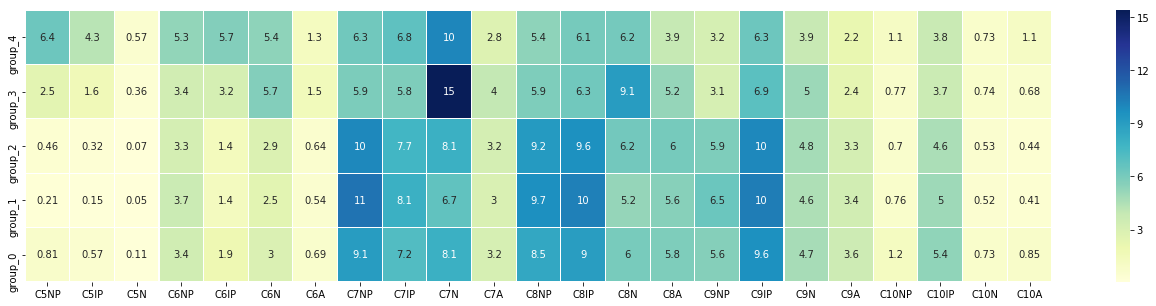

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

cut_num = len(train['群代碼'].unique())
table = pd.DataFrame(index=['group_'+str(群代碼) for 群代碼 in range(cut_num)],columns=y.columns)
#根據不同群和y_name找出其均值
for y_name in y.columns:
  for 群代碼 in range(cut_num):
    均值 = round(train[train['群代碼']==群代碼][y_name].mean(),2)
    table.loc[['group_'+str(群代碼)],[y_name]] = 均值
#繪圖
plt.figure(figsize=(23,cut_num))
sns.heatmap(table.astype(float)[::-1],annot=True,linewidths=0.1,cmap='YlGnBu')

# Def x_col,y_col

In [14]:
y_columns = y.columns.tolist()
x_columns = train.drop(y_columns+['群代碼'],axis=1).columns.tolist()
print(x_columns)
print(y_columns)

['T10', 'T50', 'T90', 'NA', 'T90-T50', 'T50-T10']
['C5NP', 'C5IP', 'C5N', 'C6NP', 'C6IP', 'C6N', 'C6A', 'C7NP', 'C7IP', 'C7N', 'C7A', 'C8NP', 'C8IP', 'C8N', 'C8A', 'C9NP', 'C9IP', 'C9N', 'C9A', 'C10NP', 'C10IP', 'C10N', 'C10A']


# features scaler

In [15]:
from sklearn.preprocessing import StandardScaler
def data_scaler(my_data,my_scaler):
  new_data = my_scaler.transform(my_data)
  return pd.DataFrame(new_data ,index=my_data.index ,columns=my_data.columns)
def inv_data_scaler(my_data,my_scaler):
  new_data = my_scaler.inverse_transform(my_data)
  return pd.DataFrame(new_data ,index=my_data.index ,columns=my_data.columns)
X_scaler = StandardScaler().fit(train[x_columns])
X_scaler

StandardScaler(copy=True, with_mean=True, with_std=True)

In [16]:
train[x_columns] = data_scaler(train[x_columns],X_scaler)
print(train.shape)
test[x_columns] = data_scaler(test[x_columns],X_scaler)
print(test.shape)

(4521, 30)
(170, 30)


# 查看分數

In [0]:
def get_score(y_pred,y_test):
  res = pd.DataFrame()
  for y_name in y_columns:
    res = res.append(metric(y_test[y_name],y_pred[y_name],y_name))
  res.loc['AVG'] = res.mean()
  return res 

# 單純建模表現

In [0]:
import warnings 
warnings.simplefilter('ignore')

In [19]:
from tqdm import tqdm_notebook as tqdm

def 單純建模結果():
  #預測值表格
  y_pred = pd.DataFrame(index = y_test.index ,columns = y_test.columns)

  #填表
  for y_name in tqdm(y_columns):
    y_pred.loc[:,y_name] = SVR().fit(train[x_columns],train[y_name]).predict(test[x_columns])

  #分數
  return get_score(y_pred,y_test)
res_1 = 單純建模結果()
res_1

,R2,RMSE,MAPE
C5NP,0.872199,0.305508,30.880549
C5IP,0.737729,0.262067,46.528714
C5N,0.799409,0.061313,215.012096
C6NP,0.151625,0.372645,6.192081
C6IP,0.859339,0.392024,9.792230
C6N,0.865364,0.607647,5.832102
C6A,0.202542,0.152569,16.623003
C7NP,0.976248,0.338942,3.520847
C7IP,0.861071,0.411871,4.425818
C7N,0.978217,0.615062,3.652725


#單純集成學習表現

In [20]:
from tqdm import tqdm_notebook as tqdm

def 單純集成學習結果():
  #預測值表格
  y_pred = pd.DataFrame(index = test.index ,columns = y_columns)
  y_test = test[y_columns]

  #填表
  for y_name in tqdm(y_columns):
    y_pred.loc[:,y_name] = 集成學習(train[x_columns],train[y_name],test[x_columns])

  #分數
  return get_score(y_pred,y_test)
res_2 = 單純集成學習結果()
res_2

,R2,RMSE,MAPE
C5NP,0.891809,0.281093,43.502759
C5IP,0.718994,0.271265,83.631291
C5N,0.934916,0.034924,41.125200
C6NP,0.144888,0.374121,6.597490
C6IP,0.895177,0.338419,9.364168
C6N,0.896161,0.533642,6.739722
C6A,0.407313,0.131530,16.322987
C7NP,0.983344,0.283831,3.158798
C7IP,0.848534,0.430053,5.252087
C7N,0.976492,0.638953,3.792353


# 分群_集成學習

In [21]:
from tqdm import tqdm_notebook as tqdm

def 分群加集成學習結果():
  #預測值空白表格
  y_pred = pd.DataFrame(index = y_test.index ,columns = y_test.columns)

  #開始填表(加入分群概念)
  for 群代碼 in tqdm(sorted(test.群代碼.unique())):
    群落_train = train.loc[train['群代碼'] == 群代碼 , :]
    群落_test  = test.loc[test['群代碼'] == 群代碼 , :]
    for y_name in tqdm(y_columns):
      y_pred.loc[群落_test.index,y_name] = 集成學習(群落_train[x_columns],
                                                   群落_train[y_name],
                                                   群落_test[x_columns])

  #分數
  return get_score(y_pred,y_test)
res_3 = 分群加集成學習結果()
res_3

,R2,RMSE,MAPE
C5NP,0.869238,0.309027,43.334582
C5IP,0.691567,0.284195,79.071446
C5N,0.831631,0.056173,189.098815
C6NP,0.025805,0.399323,6.908973
C6IP,0.858666,0.392960,9.548066
C6N,0.893440,0.540590,6.396534
C6A,0.262946,0.146677,17.791268
C7NP,0.976666,0.335949,3.538301
C7IP,0.819766,0.469119,5.979252
C7N,0.971519,0.703293,4.185545


# 分群_集成學習_調參

In [22]:
from tqdm import tqdm_notebook as tqdm

def 分群_集成學習_調參():
  #參數池
  params_1 = {
    'C': np.arange(1 ,30 ,1)
  }
  
  #預測值空白表格
  y_pred = pd.DataFrame(index = y_test.index ,columns = y_test.columns)

  #開始填表_分群_調參
  for 群代碼 in tqdm(sorted(test.群代碼.unique())):
    群落_train = train.loc[train['群代碼'] == 群代碼 , :]
    群落_test  = test.loc[test['群代碼'] == 群代碼 , :]
    for y_name in tqdm(y_columns):
      y_pred.loc[群落_test.index,y_name] = 集成學習(群落_train[x_columns],
                                                   群落_train[y_name],
                                                   群落_test[x_columns],
                                                   tuning_meta_model=True,
                                                   meta_model_params=params_1)

  #分數
  return get_score(y_pred,y_test)
res_4 = 分群_集成學習_調參()
res_4

,R2,RMSE,MAPE
C5NP,0.872794,0.304796,43.098362
C5IP,0.690754,0.284570,77.767850
C5N,0.830682,0.056331,190.571318
C6NP,0.065662,0.391069,6.881551
C6IP,0.858782,0.392799,9.533126
C6N,0.893474,0.540503,6.384749
C6A,0.265925,0.146381,17.922342
C7NP,0.976138,0.339729,3.580119
C7IP,0.806363,0.486249,6.198890
C7N,0.962951,0.802139,4.463559


# 分群_集成學習_序列預測

In [23]:
from tqdm import tqdm_notebook as tqdm

def 序列預測_集成學習_分群():
  #預測值空白表格
  y_pred = pd.DataFrame(index = y_test.index ,columns = y_test.columns)

  #開始填表(加入分群概念)
  for 群代碼 in tqdm(sorted(test.群代碼.unique())):
    
    群落_train = train.loc[train['群代碼'] == 群代碼 , :]
    群落_test  = test.loc[test['群代碼'] == 群代碼 , :]
    
    群落_X_train = 群落_train[x_columns]
    群落_X_test = 群落_test[x_columns]
    
    for y_name in tqdm(y_columns):
      群落_y_train = 群落_train[y_name]
      群落_y_pred = 集成學習(群落_X_train,
                            群落_y_train,
                            群落_X_test)
      
      y_pred.loc[群落_X_test.index,y_name] = 群落_y_pred
      
      群落_X_train[y_name] = 群落_y_train
      群落_X_test[y_name]  = 群落_y_pred

  #分數
  return get_score(y_pred,y_test)
res_5 = 序列預測_集成學習_分群()
res_5

,R2,RMSE,MAPE
C5NP,0.869238,0.309027,43.334582
C5IP,0.699407,0.280560,97.435769
C5N,0.836965,0.055276,205.373313
C6NP,0.006721,0.403215,7.897437
C6IP,0.871946,0.374042,10.061777
C6N,0.561079,1.097144,23.232976
C6A,0.244478,0.148504,15.871432
C7NP,0.983496,0.282537,3.205122
C7IP,0.869038,0.399887,4.929497
C7N,0.981350,0.569122,3.716966


# 序列預測_集成學習_分群_調參

In [24]:
from tqdm import tqdm_notebook as tqdm

def 序列預測_集成學習_分群_調參():
  #參數池_1
  params_1 = {
    'C': np.arange(1 ,30 ,1)
  }
  
  #預測值空白表格
  y_pred = pd.DataFrame(index = y_test.index ,columns = y_test.columns)

  #開始填表(加入分群概念)
  for 群代碼 in tqdm(sorted(test.群代碼.unique())):
    
    群落_train = train.loc[train['群代碼'] == 群代碼 , :]
    群落_test  = test.loc[test['群代碼'] == 群代碼 , :]
    
    群落_X_train = 群落_train[x_columns]
    群落_X_test = 群落_test[x_columns]
    
    for y_name in tqdm(y_columns):
      群落_y_train = 群落_train[y_name]
      群落_y_pred = 集成學習(群落_X_train,
                            群落_y_train,
                            群落_X_test,
                            tuning_meta_model=True,
                            meta_model_params=params_1)
      
      y_pred.loc[群落_X_test.index,y_name] = 群落_y_pred
      
      群落_X_train[y_name] = 群落_y_train
      群落_X_test[y_name]  = 群落_y_pred

  #分數
  return get_score(y_pred,y_test)
res_6 = 序列預測_集成學習_分群_調參()
res_6

,R2,RMSE,MAPE
C5NP,0.872794,0.304796,43.098362
C5IP,0.696418,0.281952,103.384659
C5N,0.798562,0.061442,207.209057
C6NP,-0.041558,0.412898,8.115982
C6IP,0.857667,0.394346,10.641652
C6N,0.505486,1.164555,24.381642
C6A,0.217439,0.151138,15.860630
C7NP,0.980446,0.307535,3.437727
C7IP,0.853026,0.423627,5.292422
C7N,0.975190,0.656408,3.997302


#分數比較

In [25]:
df = pd.DataFrame({'單純SVR':res_1.RMSE,
                   '單純集成學習':res_2.RMSE,
                   '集成學習&分群':res_3.RMSE,
                   '集成學習&分群&調參':res_4.RMSE,
                   '集成學習&分群&序列預測':res_5.RMSE,
                   '集成學習&分群&序列預測&調參':res_6.RMSE})
print('紅色代表RMSE最低')
df.style.apply(lambda x: ["background: red" if v == np.min(x) else "" for v in x], axis = 1)

紅色代表RMSE最低


,單純SVR,單純集成學習,集成學習&分群,集成學習&分群&調參,集成學習&分群&序列預測,集成學習&分群&序列預測&調參
C5NP,0.305508,0.281093,0.309027,0.304796,0.309027,0.304796
C5IP,0.262067,0.271265,0.284195,0.28457,0.28056,0.281952
C5N,0.0613127,0.0349245,0.0561728,0.0563308,0.0552757,0.061442
C6NP,0.372645,0.374121,0.399323,0.391069,0.403215,0.412898
C6IP,0.392024,0.338419,0.39296,0.392799,0.374042,0.394346
C6N,0.607647,0.533642,0.54059,0.540503,1.09714,1.16455
C6A,0.152569,0.13153,0.146677,0.146381,0.148504,0.151138
C7NP,0.338942,0.283831,0.335949,0.339729,0.282537,0.307535
C7IP,0.411871,0.430053,0.469119,0.486249,0.399887,0.423627
C7N,0.615062,0.638953,0.703293,0.802139,0.569122,0.656408


# 保存res

In [26]:
res_1.to_excel('/content/drive/My Drive/台塑輕油案子/預測方法結果/單純SVR.xlsx')
res_2.to_excel('/content/drive/My Drive/台塑輕油案子/預測方法結果/單純集成學習(SVR).xlsx')
res_3.to_excel('/content/drive/My Drive/台塑輕油案子/預測方法結果/集成學習&分群(SVR).xlsx')
res_4.to_excel('/content/drive/My Drive/台塑輕油案子/預測方法結果/集成學習&分群&調參(SVR).xlsx')
res_5.to_excel('/content/drive/My Drive/台塑輕油案子/預測方法結果/集成學習&分群&序列預測(SVR).xlsx')
res_6.to_excel('/content/drive/My Drive/台塑輕油案子/預測方法結果/集成學習&分群&序列預測&調參(SVR).xlsx')
print('save done!')

save done!
